<a href="https://colab.research.google.com/github/patero22/PyTorch_Course/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural network classification with PyTorch

## 1. Make classification data nad get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Make a 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [5]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                      "X2": X[:, 1],
                      "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


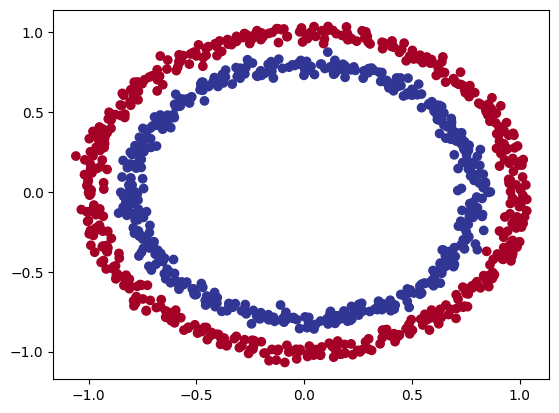

In [6]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

## 1.1 Check input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Sample of X: {X_sample} , sample of y: {y_sample}")
print(f"Shape of sample of X: {X_sample.shape} , shape of sample of y: {y_sample.shape}")

Sample of X: [0.75424625 0.23148074] , sample of y: 1
Shape of sample of X: (2,) , shape of sample of y: ()


### 1.2 Turn data into tensors and create train and test splits

In [9]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [10]:
# Turn data into tensors
import torch
torch.__version__
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [11]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [12]:
type(X)

torch.Tensor

In [13]:
# Split data into training a train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model
Let's build a model to classify our blue and red dots

To do so, we'll use PyTorch's to:
1. Setup device agnostic code so our code will run on a accekerator (GPU) if there is one available
2. Create a model class (by subclassing nn.Module)
3. Define a loss function and optimizer
4. Create a training and test loop

In [14]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now we've setup device agnostic code, let's build a model that:

1. Sublclasses 'nn.Module'
2. Create 2 'nn.Linear()' layers that are capable of handling the shapes of our data
3. Define a forward() method that outlines the forward pass (or forward computation) of the model
4. Instatate an instance of our model and send it to the target device

In [15]:
# 1. Construct a model that cublaccese nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    # 3. Define a forward() method that outlines the forward pass (or forward computation) of the model
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

# 4. Instatate an instance of our model and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
print(device)

cuda


In [17]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [18]:
# Let's replicate the model above using nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0


Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0477, -0.3008],
                      [-0.1354,  0.6845],
                      [ 0.6121, -0.5183],
                      [ 0.5354, -0.5001],
                      [ 0.2879, -0.3789]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.6044, -0.4167, -0.1272, -0.1951,  0.2752], device='cuda:0')),
             ('1.weight',
              tensor([[-0.3539,  0.2240, -0.3083,  0.3871, -0.2078]], device='cuda:0')),
             ('1.bias', tensor([0.1848], device='cuda:0'))])

In [20]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}")
print(f"Shape of untrained preds: {untrained_preds.shape}")

Length of predictions: 200
Shape of untrained preds: torch.Size([200, 1])


In [21]:
untrained_preds[:10]

tensor([[ 0.0253],
        [ 0.0752],
        [-0.2497],
        [ 0.1038],
        [-0.4783],
        [-0.4460],
        [-0.1241],
        [-0.2468],
        [-0.2396],
        [ 0.0761]], device='cuda:0')

### 2.1 Setup loss functions and optimizer

For example for regression you might want MAE or MSE

For classification you might want binary cross entropy or categorical cross entropy

As a reminder, the loss function measures how wrong our predictions are

And for optimizers, two of the most common and useful are SGD and Adam

* For loss we're going to user torch.nn.BECWithLogitsLoss()



In [22]:
# Setup the loss function

#loss_fn = nn.BCELoss() #also exist
loss_fn = nn.BCEWithLogitsLoss() #sigmoid activation function built-in

# Setup the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [23]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Train model

To train our model, we're going to need to build a training loop

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward
5. Optimizer step

### 3.1 Going from raw logits -> prediction propabilities -> prediction labels
Our model outputs are going to be raw **logits**.
We can convert these logits into prediction probabilities using the sigmoid activation function.
These probabilities will be the prediction labels. by rounding them or taking argmax()

In [24]:
# View the first 5 outputs of the forward pass on the test data
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.0253],
        [ 0.0752],
        [-0.2497],
        [ 0.1038],
        [-0.4783]], device='cuda:0')

In [25]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [26]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5063],
        [0.5188],
        [0.4379],
        [0.5259],
        [0.3827]], device='cuda:0')

For out prediction probability values, we need to performa range-style rounding on them:
* y_pred_probs >= 0.5 -> 1 class 1
* y_pred_probs < 0.5 -> 0 class 2

In [27]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In fyll
y_preds_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_preds_labels.squeeze()))

# Get rid of extra dimensions
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 0., 1., 0.], device='cuda:0')

### 3.2 Buidling a training loop

In [28]:
torch.manual_seed(42)

torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Building training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # trun logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    #loss = loss_fn(torch.sigmoid(y_logits), y_train) # nn>BCELoss expects prediction probabilities as input
    loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expects raw logits as input
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

        # Print out what's happenin'
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.70295, Acc: 46.88% | Test loss: 0.70742, Test acc: 43.00%
Epoch: 10 | Loss: 0.69702, Acc: 47.62% | Test loss: 0.70159, Test acc: 48.00%
Epoch: 20 | Loss: 0.69481, Acc: 49.00% | Test loss: 0.69909, Test acc: 47.00%
Epoch: 30 | Loss: 0.69391, Acc: 49.88% | Test loss: 0.69785, Test acc: 46.50%
Epoch: 40 | Loss: 0.69350, Acc: 50.25% | Test loss: 0.69713, Test acc: 46.50%
Epoch: 50 | Loss: 0.69330, Acc: 50.88% | Test loss: 0.69666, Test acc: 46.50%
Epoch: 60 | Loss: 0.69319, Acc: 50.62% | Test loss: 0.69633, Test acc: 46.50%
Epoch: 70 | Loss: 0.69312, Acc: 50.88% | Test loss: 0.69609, Test acc: 47.50%
Epoch: 80 | Loss: 0.69308, Acc: 51.38% | Test loss: 0.69591, Test acc: 47.50%
Epoch: 90 | Loss: 0.69305, Acc: 51.12% | Test loss: 0.69576, Test acc: 47.50%


In [29]:
loss_fn #this required logits as input

BCEWithLogitsLoss()

In [30]:
loss_fn_without_logits = nn.BCELoss()
loss_fn_without_logits

BCELoss()

## 4. Make predictions and evaluate the model

From the metrics it look like our model isn't learning anything...

So to inspect it let's make some predicions and make them visual

To do so we'll import `plot_decison_boundry()`

In [31]:
import requests
from pathlib import Path

# Dowloand helper functions from Learn PyTorch repo (if it's not already dowloanded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_decision_boundary


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

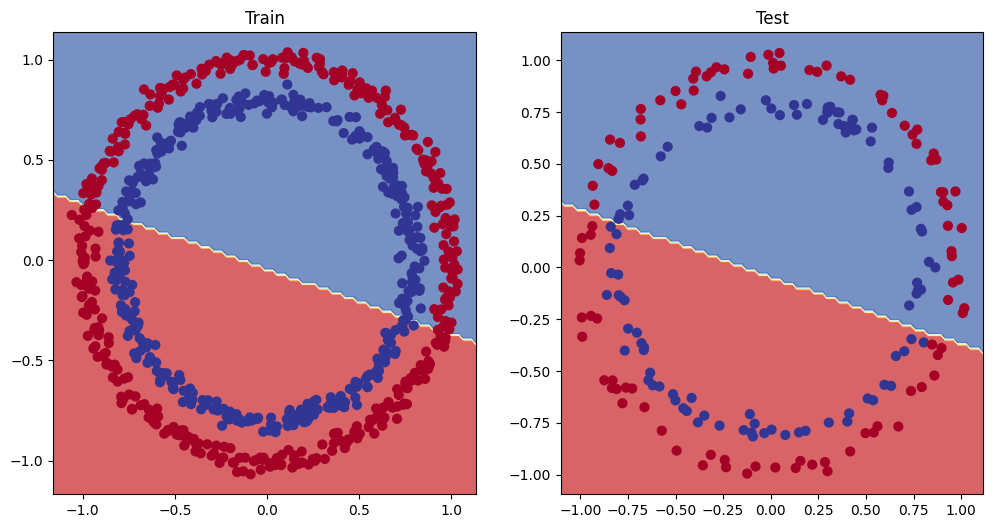

In [32]:
# Plot decision boundry of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)
plt

## 5. Improving a model (from a model perspectives)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perpsective becasue thea deal directly with the model rather than the data

And beacasue the options are all values we can change, they can change by **hyperparameters**

Let's try improve our model by:
* Addinf more hidden units: 5->10
* Increase the number of layers: 2->3
* Increase the number of epochs: 100->1000

In [34]:
class CirecleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x))) #this way or writting operetaions leverages speed ups where possible behind the scenes

model_1 = CirecleModelV1().to(device)
model_1

CirecleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [35]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [36]:
# Write a training and testing loop for model_1
torch.manual_seed(42)

torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits,
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

        # Print out what's happenin'
        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 200 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 300 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 400 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 500 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 600 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 700 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 800 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 900 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%


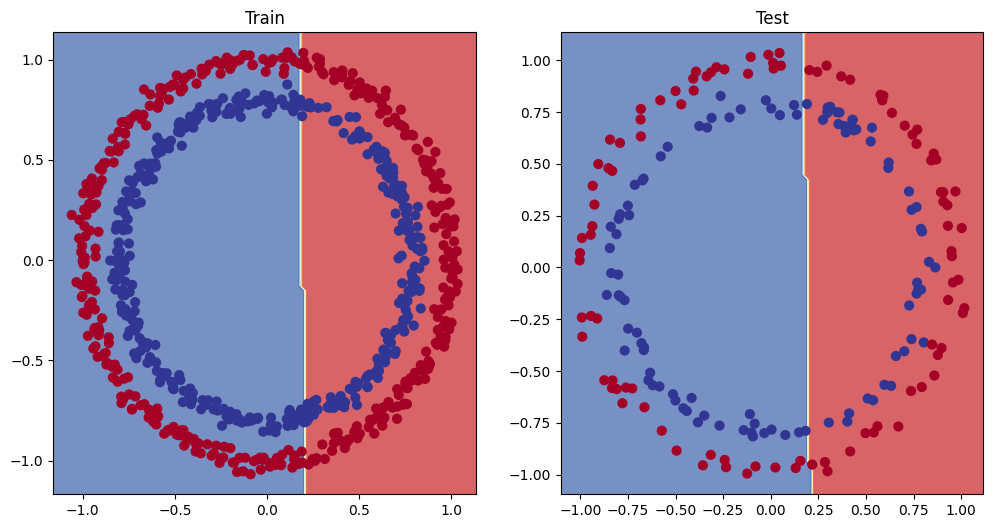

In [37]:
# Plot the decision boundry
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)
